In [1]:
# This is for testing Altair Fizeau PSF centering algorithms

# created 2018 Nov. 2 by E.S.

## SECTION TO INITIALIZE

In [1]:
# import stuff

import urllib
import numpy as np
import matplotlib.pyplot as plt

import PynPoint

from PynPoint import Pypeline
from PynPoint.IOmodules.Hdf5Reading import Hdf5ReadingModule
from PynPoint.IOmodules.FitsWriting import FitsWritingModule
from PynPoint.IOmodules.FitsReading import FitsReadingModule
from PynPoint.IOmodules.TextReading import ParangReadingModule
from PynPoint.ProcessingModules import PSFpreparationModule, \
                                       PcaPsfSubtractionModule, \
                                       ContrastCurveModule, \
                                       FluxAndPosition, \
                                    StackingAndSubsampling
from PynPoint.ProcessingModules.StarAlignment import StarCenteringModule
from PynPoint.ProcessingModules.StackingAndSubsampling import DerotateAndStackModule
from PynPoint.ProcessingModules.FluxAndPosition import FakePlanetModule
#from PynPoint.Util import AnalysisTools

In [2]:
# define workspaces and initialize Pypeline

working_place = "./pynpoint_experimentation_altair/working_place/"
input_place = "./pynpoint_experimentation_altair/input_place/"
output_place = "./pynpoint_experimentation_altair/output_place/"

pipeline = Pypeline(working_place_in=working_place,
                    input_place_in=input_place,
                    output_place_in=output_place)

# now a *.ini file has been generated (this includes the PIXSCALE), if no pre-existing one was there

Initiating PynPoint... [DONE]


In [3]:
## IF THE *INI FILE WAS NEWLY GENERATED, EDIT THE *INI FILE TO SET
## PIXSCALE = 0.0107

# TEST USING PYNPOINT INFRASTRUCTURE

## SECTION TO READ IN DATA

In [3]:
# read in science FITS files 
# (should have PARANG=0 in all headers, so as to keep the PSF in the same original orientation on the array; 
# we need to wait to correct for PARANG later)

read_science = FitsReadingModule(name_in="read_science",
                                 input_dir=None,
                                 image_tag="science",
                                 check=True)

pipeline.add_module(read_science)

In [4]:
# confirm PIXSCALE change

pixscale_config = pipeline.get_attribute("config", "PIXSCALE")
print("Plate scale for /config/ is "+str(pixscale_config))
#pixscale_sci = pipeline.get_attribute("science", "PIXSCALE")
#print("Plate scale for /science/ is "+str(pixscale_sci))

Plate scale for /config/ is 0.0107


In [5]:
# read in PSF reference FITS files (i.e., unsaturated frames)
# (these do not have any PARANG in the header, but it probably doesn't matter)

read_ref_psf = FitsReadingModule(name_in="read_ref_psf",
                                 input_dir=input_place+'ref_psf/',
                                 image_tag="ref_psf",
                                 check=True)

pipeline.add_module(read_ref_psf)

## SECTION 0: NO CENTERING OF PSFS; JUST PUT INTO A CUBE

In [7]:
# write cube of non-centered frames

write_noCentering_PAcorrected = FitsWritingModule(file_name="altair_unsat_psfs_PAcorrected_noCentering.fits",
                              name_in="write_noCentering_PAcorrected",
                              output_dir=output_place,
                              data_tag="ref_psf")
                              
pipeline.add_module(write_noCentering_PAcorrected)


pipeline.run()

Validating Pypeline... [DONE]


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute DIT (=ESO DET DIT) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute LATITUDE (=ESO TEL GEOLAT) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute LONGITUDE (=ESO TEL GEOLON) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:207: UserWarning: Non-static attribute EXP_NO (=ESO DET EXP NO) not found in the FITS header.
  "header." % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:207: UserWarning: Non-static attribute ND

Running FitsReadingModule... [DONE]


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute INSTRUMENT (=INSTRUME) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:207: UserWarning: Non-static attribute DATE (=DATE-OBS) not found in the FITS header.
  "header." % (item[0], fitskey))


Running FitsReadingModule... [DONE]
Running FitsWritingModule... [DONE]


## SECTION 1: CENTER UNSATURATED PSFS

In [6]:
# Try StarCenteringModule
'''
try_StarCenteringModule = StarCenteringModule(name_in='try_StarCenteringModule', 
                                              image_in_tag='ref_psf', 
                                              image_out_tag='ref_psf_StarCenteringModule', 
                                              mask_out_tag=None, 
                                              fit_out_tag='center_fit', 
                                              method='full', 
                                              interpolation='spline', 
                                              radius=0.16, 
                                              sign='positive')

pipeline.add_module(try_StarCenteringModule)


# write cube of centered frames (no PA correction)
write_StarCenteringModule_noPAchange = FitsWritingModule(file_name="altair_unsat_psfs_noPAchange_StarCenteringModule.fits",
                              name_in="write_StarCenteringModule_noPAchange",
                              output_dir=output_place,
                              data_tag="ref_psf_StarCenteringModule")
                              
pipeline.add_module(write_StarCenteringModule_noPAchange)
'''

# derotate based on PA
derotate_frames = StackingAndSubsampling.DerotateAndStackModule(name_in='derotate_frames', 
                                         image_in_tag='ref_psf_StarCenteringModule', 
                                         image_out_tag='ref_psf_StarCenteringModule_derotated', 
                                         derotate=True, 
                                         stack=None, 
                                         extra_rot=0.0)

pipeline.add_module(derotate_frames)

# write cube of centered frames (with PA correction; for unsaturated PSFs, there's no PA info applicable)
'''
write_StarCenteringModule_PAcorrected = FitsWritingModule(file_name="altair_unsat_psfs_PAcorrected_StarCenteringModule.fits",
                              name_in="write_StarCenteringModule_PAcorrected",
                              output_dir=output_place,
                              data_tag="ref_psf_StarCenteringModule_derotated")
                              
pipeline.add_module(write_StarCenteringModule_PAcorrected)
'''

pipeline.run()

Validating Pypeline... [DONE]


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute INSTRUMENT (=INSTRUME) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute DIT (=ESO DET DIT) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute LATITUDE (=ESO TEL GEOLAT) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:172: UserWarning: Static attribute LONGITUDE (=ESO TEL GEOLON) not found in the FITS header.
  % (item[0], fitskey))
/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/IOmodules/FitsReading.py:207: UserWarning: Non-static attribute EXP_NO (=ESO DET E

Running FitsReadingModule... [DONE]


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Running StarCenteringModule... [DONE]
2D Gaussian fit could not converge on 4 image(s). [WARNING]


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/PynPoint/Core/DataIO.py:445: UserWarning: No attribute found - requested: PARANG.
  warnings.warn("No attribute found - requested: %s." % name)


TypeError: 'NoneType' object has no attribute '__getitem__'

In [3]:
# read in HDF5 file and plot some stuff

hdf5_reading = PynPoint.IOmodules.Hdf5Reading.Hdf5ReadingModule(name_in='hdf5_reading', 
                                                 input_filename="PynPoint_database.hdf5", 
                                                 input_dir=working_place, 
                                                 tag_dictionary=None)

pipeline.add_module(hdf5_reading)

pipeline.run()

Validating Pypeline... [DONE]
Running Hdf5ReadingModule... [DONE]


In [4]:
centering_results = pipeline.get_data("center_fit")

In [5]:
np.shape(centering_results)

(487, 12)

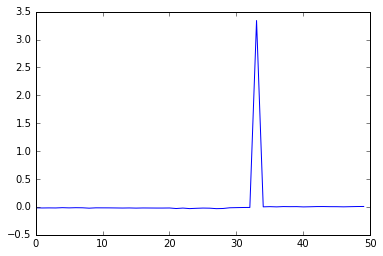

In [19]:
%matplotlib inline
plt.plot(centering_results[100:150,0])
#plt.ylim([-1,1])
plt.show()

# TEST USING VANESSA'S CENTERING METHOD (TBD)

In [7]:
from lmircam_tools import overlap_psfs

In [ ]:
# read in images individually, determine center, then shift the image with sub-pixel precision

In [8]:
psf_loc = overlap_psfs.find_airy_psf(image)

NameError: name 'image' is not defined

# TEST USING CROSS-CORRELATION OF SYNTHETIC PSF (TBD)